# Shrinkage Estimators
This notebook tests four different mean estimators on simulated data:
1. Maximum Likelihood
2. Multi Sample Size James-Stein Estimator. Within-group variances estimated independently.
3. Multi Sample Size Pooled James-Stein Estimator. Pooled within-group variance estimation.
4. MCMC

For the simulated data: True group means are sampled from a normal distribution. Within-group observations are sampled from a normal distribution with variance that is either identical across groups or is different across groups (and sampled from a log-normal distribution). Sample sizes are sampled from a Gamma distribution.

In [1]:
from collections import OrderedDict
from functools import reduce
import sys

import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import pandas as pd
import scipy
import seaborn as sns
from pystan import StanModel

from status_printer import StatusPrinter

status_printer = StatusPrinter(sys.stdout)
sns.set_style('white')
sns.set_palette(sns.color_palette('pastel'))
%matplotlib inline

### Config parameters

    :n_iter        Number of simulations to run.
    :k:            Number of groups
    :gamma_scale:  Parameter on the distribution of sample sizes.
    :gamma_shape:  Parameter on the distribution of sample sizes.
    :mu:           The true mean of the true group means 
    :tau:          The true standard deviation of the true group means
    :epsilon:      The true standard deviation of the observations within each group.
                   Set to None if you want different groups to have different variances
                   of their observations.
    :tau_v:        The true standard deviation for the lognormal distribution of epsilons. 
                   Use this only if you want different groups to have different epsilons.
    :mu_v:         The true mean parameter for the lognormal distribution of epsilons.
                   Use this only if you want different groups to have different epsilons.
    :stan_chains': Number of MCMC chains
    :stan_iter':   Number of MCMC iterations. (Burn-in is stan_iter//2.)    

### Constants

In [2]:
gray = np.array([.7, .7, .7])
pink = np.array([237, 38, 133])/256
blue = np.array([58, 195, 242])/256
orange = np.array([245, 128, 50])/256

algos = ['MLE', 'MSS James-Stein', 'MSS Pooled James-Stein', 'MCMC']

algo_colors = {'MLE': gray,
               'MSS James-Stein': pink,
               'MSS Pooled James-Stein': blue,
               'MCMC': orange}

### Helper Functions

In [3]:
def mse(x, y):
    """
    Returns the Mean Squared Error between two numpy arrays, x and y.
    """
    return ((x-y)**2).mean()

In [4]:
def flatten(arr):
    return reduce(lambda x, y: np.concatenate((x, y)), arr)

In [5]:
def generate_data(config):
    """
    Creates a DataFrame of data using config parameters. If all groups share the same within-group
    variance parameter, then epsilon must be a set in config. If the groups are allowed to have
    different within-group variance parameters, then mu_v and tau_v must be set instead.
    
    :param config: Config dictionary.
    :return: df: A DataFrame with two columns: 'x' contains observations and 'group_id' contains the group IDs.
             group_mus_ser: A pandas Series of the true group means (thetas).
    """
    
    mu = config['mu']
    tau = config['tau']
    epsilon = config.get('epsilon', None)
    tau_v = config.get('tau_v', None)
    mu_v = config.get('mu_v', None)
    k = config['k']
    gamma_scale = config['gamma_scale']
    gamma_shape = config['gamma_shape']
    
    group_sizes = np.ceil(random.gamma(gamma_shape, 
                                       scale=gamma_scale,
                                       size=k)).astype(int) 
    
    # Within group variance parameters can be either shared or different across groups
    if epsilon is None:
        epsilons = np.sqrt(np.random.lognormal(mu_v, tau_v, k))
    else:
        epsilons = [epsilon] * k
    
    group_ids = range(0,k)
    group_mus = tau * random.randn(k) + mu
    group_mus_ser = pd.Series(group_mus, index=group_ids, name='group_mu')
    group_ids_long = flatten([[id]*size for id, size in zip(group_ids, group_sizes)])
    data = flatten(np.array(
        [epsilon * random.randn(n) + group_mu 
         for n, group_mu, epsilon in zip(group_sizes, group_mus, epsilons)]))

    df = pd.DataFrame({'x': data, 'group_id': group_ids_long})
    
    return df, group_mus_ser

In [6]:
def common_stats(df, config):
    """
    Preprocessing. Computes some common statistics used by multiple estimators.
    
    :param df: A DataFrame with two columns. The first should be a column of observations. 
        The column should be named 'x' or be specified in the data_col field of config.
        The second column is group IDs and should be called 'group_id' or be specified
        in the group_id_col column of config.
    :param config: Config dictionary.
    :returns stats: A DataFrame where each row represents a group, and the columns correspond
        to various statistics.
    """
    
    group_id_col = config.get('group_id_col', 'group_id')
    data_col = config.get('data_col', 'x')
    
    df = df.assign(
        mean = df.groupby(group_id_col)[data_col].transform(np.mean),
        n = df.groupby(group_id_col)[data_col].transform(len))

    stats = df.groupby(group_id_col)[data_col].agg({
        'mean': np.mean,
        'n': len,
        'dof': lambda x: max(len(x) - 1, 1),
        'std2': np.var})
    
    # n=1 edge case.
    default_std2 = (df.query('n > 1')[data_col] - df.query('n > 1')['mean']).var()
    stats.loc[stats['n'] < 2, 'std2'] = default_std2
    stats.loc[stats['n'] < 2, 'dof'] = 1
    
    stats = stats.assign(
        btw_group_std2 = df.groupby(group_id_col)[data_col].mean().var(),
        global_mean = stats['mean'].mean(),
        pooled_std2 = (stats['std2'] * stats['dof']).sum() / (stats['dof'].sum()))
        
    stats = stats.assign(
        sem2 = stats['std2'] / stats['n'],
        pooled_sem2 = stats['pooled_std2'] / stats['n'])

    return stats


In [7]:
def plot_mses(x, MSEs, algos, xlabel, fig_name):
    """
    :param x: Array of values for the horizontal axis
    :param MSEs: DataFrame of MSE's, where each column corresponds to an algorithm
        and each row corresponds to a value of x
    :param algos: List of strings corresponding to the algorithms you want to plot
    """
    plt.figure()
    
    for algo in algos:
        plt.plot(x, MSEs[algo], label=algo, linewidth=2, color=algo_colors[algo])
    
    plt.legend(loc='best')
    plt.ylabel('MSE')
    plt.xlabel(xlabel, fontsize=16)
    plt.xlim([x.min(), x.max()])
    plt.ylim([0, plt.ylim()[1]])
    sns.despine()  
    plt.savefig(f'{fig_name}.png', dpi=200, bbox_inches='tight')

### Estimator Functions

In [8]:
def multi_sample_size_js_estimator(stats):
    """
    Adds group mean estimates to the stats DataFrame using the multi-sample size James-Stein Estimator.
    Uses group variances that are estimated independently (i.e. unpooled)
    """
    
    stats = stats.assign(
        B_hat_js = (stats['sem2'] / stats['btw_group_std2']).clip(0,1))
    
    stats = stats.assign(
        theta_hat_js = stats['B_hat_js'] * stats['global_mean'] + (1 - stats['B_hat_js']) * stats['mean'])

    return stats

def multi_sample_size_js_estimator_pooled(stats):
    """
    Adds group mean estimates to the stats DataFrame using the multi-sample size James-Stein Estimator.
    Uses a pooled estimate of within-group variances.
    """    
    
    stats = stats.assign(
        B_hat_jsp = (stats['pooled_sem2'] / stats['btw_group_std2']).clip(0,1))
    
    stats = stats.assign(
        theta_hat_jsp = stats['B_hat_jsp'] * stats['global_mean'] + (1 - stats['B_hat_jsp']) * stats['mean'])

    return stats

def stan_model(config):
    """
    Partial pooling model where group means (theta_i's) 
    are sampled from N(mu, tau^2) and the observations 
    within groups have shared variance epsilon^2.
    
    Based on Chris Fonnesbeck's PyStan primer
    http://mc-stan.org/documentation/case-studies/radon.html
    """
    
    # Python string formatting doesn't work with Stan code.
    if config['k'] != 25:
        raise ValueError(
            "Please set group count parameters to the value in config['k']")
    
    model_code = """
        data {
          int<lower=0> N; 
          int<lower=1,upper=25> group[N];
          vector[N] y;
        } 
        parameters {
          vector[25] theta;
          real mu;
          real<lower=0,upper=200> tau;
          real<lower=0,upper=200> epsilon;
        } 
        transformed parameters {
          vector[N] y_hat;
          for (i in 1:N)
            y_hat[i] <- theta[group[i]];
        }
        model {
          mu ~ normal(0, 1);
          theta ~ normal (mu, tau);
          y ~ normal(y_hat, epsilon);
        }"""

    return StanModel(model_code=model_code)

def stan_estimator(df, config):
    
    group_id_col = config.get('group_id_col', 'group_id')
    data_col = config.get('data_col', 'x')

    data = {'N': len(df),
            'group': df[group_id_col] + 1, # Stan counts start at 1
            'y': df[data_col]}
    
    fit = config['sm'].sampling(data=data, 
                                iter=config['stan_iter'], 
                                chains=config['stan_chains'])
    return fit['theta'].mean(0)

### Simulation Functions

In [9]:
def run_iter(config):
    """ 
    Generates true means and data for multiple groups.
    Then estimates those means using a variety of methods.
    
    Returns 
    """
    # Generate data and compute some commonly used stats.
    df, group_mus_ser = generate_data(config)
    stats = common_stats(df, config)
    
    # James-Stein Estimator (and also get MLE for free)
    stats = multi_sample_size_js_estimator(stats)
    mse_mle = mse(stats['mean'], group_mus_ser)
    mse_js = mse(stats['theta_hat_js'], group_mus_ser)
    
    # Pooled James-Stein Estimator
    stats = multi_sample_size_js_estimator_pooled(stats)
    mse_jsp = mse(stats['theta_hat_jsp'], group_mus_ser)

    # MCMC Estimator
    if config['run_stan']:
        stats = stats.assign(
            theta_hat_stan = stan_estimator(df, config))
        mse_stan = mse(stats['theta_hat_stan'], group_mus_ser)
    else:
        mse_stan = np.nan
        
    results = {'MLE': mse_mle,
               'MSS James-Stein': mse_js,
               'MSS Pooled James-Stein': mse_jsp,
               'MCMC': mse_stan}

    return results

def run_iterations(config):
    """
    Runs multiple simulations and then averages the Mean Squared Errors
    across simulations.
    """
    
    n_iter = config['n_iter']
    model_MSEs = pd.DataFrame(columns=algos)
    for i in range(n_iter):
        model_MSEs = model_MSEs.append(run_iter(config), ignore_index=True)
    
    return model_MSEs.mean()

### Simulations with a shared within-group variance (but different sample sizes)

In [10]:
config = {
    'n_iter': 2500,
    'k': 25,
    'gamma_scale': 10,
    'gamma_shape': 1.5,
    'mu': 0,
    'tau': 3,
    'tau_v': None,
    'mu_v': None,
    'run_stan': True,
    'stan_chains': 4,
    'stan_iter': 1000
}
config['sm'] = stan_model(config)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0d64bf795c8d6ad9d7d55ef8f6b4da8e NOW.


In [11]:
epsilons = np.arange(3, 7, .3)
MSEs_shared = pd.DataFrame(columns=['MLE', 'MSS James-Stein', 'MSS Pooled James-Stein', 'MCMC'])
for i, epsilon in enumerate(epsilons):
    status_printer.print_status(f"Step {i+1} of {len(epsilons)}")
    config['epsilon'] = epsilon
    MSEs_shared = MSEs_shared.append(run_iterations(config), ignore_index=True)


Step 14 of 14

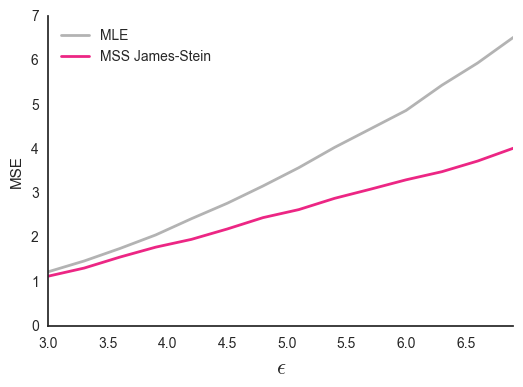

In [12]:
plot_mses(epsilons, MSEs_shared, ['MLE', 'MSS James-Stein'], 
          r'$\epsilon$', 'fig_shared_2')

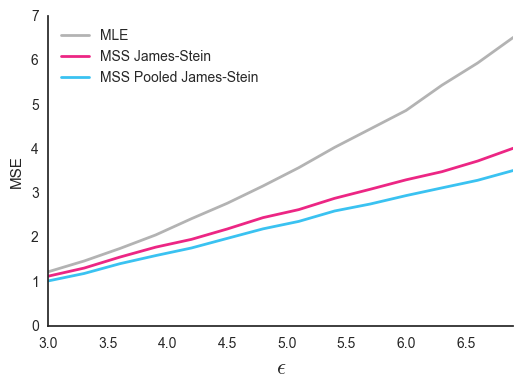

In [13]:
plot_mses(epsilons, MSEs_shared, ['MLE', 'MSS James-Stein', 'MSS Pooled James-Stein'], 
          r'$\epsilon$', 'fig_shared_3')

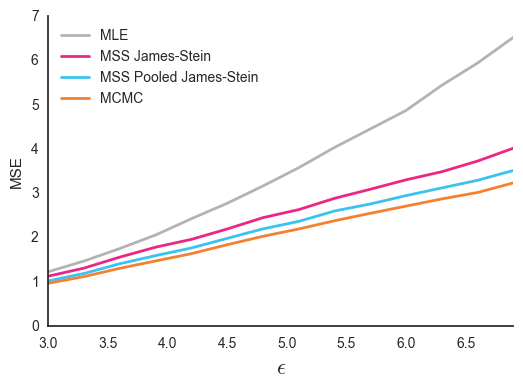

In [14]:
plot_mses(epsilons, MSEs_shared, ['MLE', 'MSS James-Stein', 'MSS Pooled James-Stein', 'MCMC'], 
          r'$\epsilon$', 'fig_shared_4')

### Simulations with a variable within-group variances (and different sample sizes)

The true variance (epsilon_^{2}_i) of the observations within each group is itself sampled from a log-normal distribution parametrized by `mu_v` and `tau^{2}_v`. These simulations explore a part of this space by setting `mu_v` and `tau^{2}_v` to systematically increasing values of a `v` parameter.

In [23]:
config = {
    'n_iter': 15000,
    'k': 25,
    'gamma_scale': 6,
    'gamma_shape': 1.5,
    'mu': 0,
    'tau': 3,
    'tau_v': None,
    'mu_v': None,
    'run_stan': False
}

In [24]:
vs = np.arange(1, 1.9, .07)
MSEs_unshared = pd.DataFrame(columns=['MLE', 'MSS Pooled James-Stein', 'MSS James-Stein'])
for i, v in enumerate(vs):
    status_printer.print_status(f"Step {i+1} of {len(vs)}")
    config['tau_v'] = np.sqrt(v) 
    config['mu_v'] = v
    MSEs_unshared = MSEs_unshared.append(run_iterations(config), ignore_index=True)

Step 13 of 13

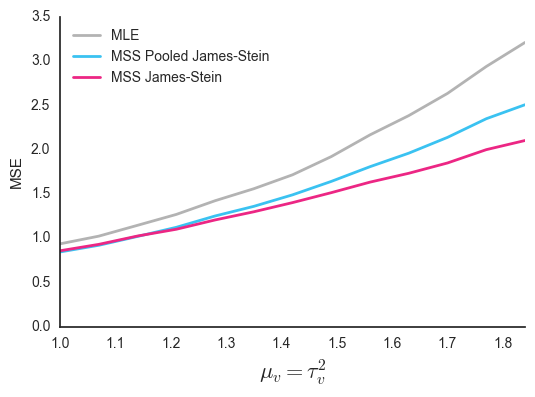

In [25]:
plot_mses(vs, MSEs_unshared, ['MLE', 'MSS Pooled James-Stein', 'MSS James-Stein'], 
          r'$\mu_{v} = \tau^{2}_{v}$', 'fig_unshared_3')

# Movie Plots

In [18]:
def plot_movies(movies, stats, fig_name, show_shrinkage=True):
    plt.figure(figsize=[11,2])
    colors = sns.color_palette("Set2", 3)
    names = ['Jaws', 'Fargo', 'Some Obscure Movie']
    text_pos = [6.2, 7.4, 8.2]
    for i, name in enumerate(names):
        ratings = movies.query('group_id == @i')['rating']
        x_i = stats.loc[i,'mean']
        theta_i = stats.loc[i,'theta_hat_js']
        plt.scatter(ratings, [0]*len(ratings), color=colors[i], s=40, label=name)
        plt.text(text_pos[i], 0.02, name, ha='center', color=colors[i], fontsize=16, weight='bold')
        plt.plot([x_i], 0, 'd', color=colors[i], linewidth=2, markersize=12)
        plt.ylim([-0.04, .04])
        plt.xlabel('Movie Ratings', fontsize=14)  
        plt.gca().yaxis.set_major_locator(plt.NullLocator())

        if show_shrinkage:
            plt.annotate("", xy=(theta_i, -0.04), xytext=(x_i, 0), 
                         arrowprops=dict(facecolor=colors[i], 
                                         edgecolor='none', width=3))
        
    sns.despine(left=True)
    plt.savefig(f'{fig_name}.png', dpi=200, bbox_inches='tight')

In [19]:
group_ids = [  0,   0,   0,   0,    0,   0,    0,     0,   0, 0,    0,   1,   1,   1,   1,   1,   1,   1,   2,   2]
ratings   = [5.2, 5.3, 5.5, 6.0, 6.05, 6.3, 6.35,  6.42, 6.5, 6.6,  6.8, 7.0, 7.3, 7.5, 7.6, 7.8, 8.3, 8.35, 7.2, 8.5]
movies = pd.DataFrame({'group_id': group_ids, 'rating': ratings})

In [20]:
stats = common_stats(movies, {'data_col': 'rating'})
stats = multi_sample_size_js_estimator(stats)

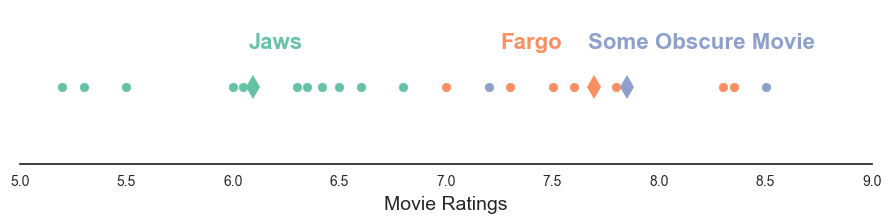

In [21]:
plot_movies(movies, stats, 'fig_movies', show_shrinkage=False)

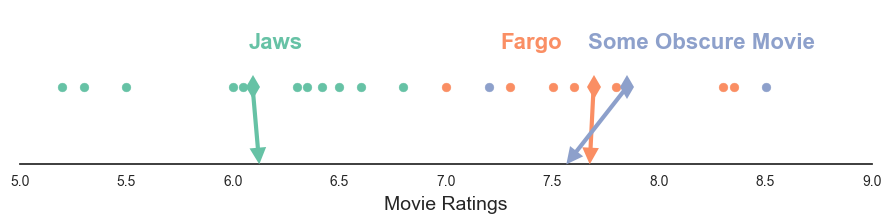

In [22]:
plot_movies(movies, stats, 'fig_movies_shrinkage', show_shrinkage=True)